# Moon Sensitivity of Australian Share Market and Trend Prediction
Ken Takekura<br>
10 Jul 2020<br>
## 1. Introduction
Moon phase has been thought to affect human mood and behaviour. In the world of investment, some traders believe it also affects price movement of shares. General belief is that share prices tend to go up around new moon and go down around full moon.<br>
This analysis investigate whether this belief stands true in Australian share market, and it also seeks possibility of trend prediction based on moon phase using machine learning techniques.<br>
Throughout the analysis, S&P/ASX200 ETF (^AXJO) is used as the market price indicator, which is observed in combination with four moon phases: New moon, 1st quarter, full moon, 3rd quarter.<br>
Goal of this analysis is to find:
1. How the market trend shifted on moon phase days, comparing 5 trading days before and after the day.<br>
2. In what condition and how likely can a trader achieve 5%< return from moon phase day.<br>
3. Whether a acceptable level of trend prediction is achievable using two machine learning techniques: Multiple Linear Regression and Polynomial Regression.<br>

*Note: The purpose of this analysis is not to provide advice for share traders. If you are seeking professional advice, please consult with a professional financial adviser and trade at your own risk.

## 2. Data Source
- <u>Yahoo Finance</u><br>
Price data of ^AXJO (2 Jan 2001 - 13 Jul 2020)<br>
https://query1.finance.yahoo.com/v7/finance/download/^AXJO?period1=978307200&period2=1594598400&interval=1d&events=history<br>
- <u>Koyomi no page</u><br>
Lunar phase data in 2001 - 2020<br>
http://koyomi.vis.ne.jp/directjp.cgi?http://koyomi.vis.ne.jp/databox.htm

## 3. Market Trend Shift around Moon Phase
In this section, direction and degree of market trend around moon phase days will be observed.<br>
Time span to be measured is 5 trading days before and after moon phase day.
### 3.1. Data Acquisition and Pre-processing
First necessary packages will be imported.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime as dt
import calendar
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.externals.six import StringIO
import pydotplus
from sklearn import tree
import matplotlib.image as mpimg

Get S&P/ASX200 price data and create pandas data frame.

In [2]:
axjo = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/^AXJO?period1=978307200&period2=1594598400&interval=1d&events=history')
axjo_close = axjo[['Date','Close']].replace('-','', regex=True)
axjo_close.head()

,Date,Close
0,20010102,3261.100098
1,20010103,3235.699951
2,20010104,3293.800049
3,20010105,3300.399902
4,20010108,3264.300049


Get moon phase data as well.

In [3]:
moon = pd.DataFrame(columns=['date','hour','minute','phase'])
for i in range(2001,2021):
    year = str(i)
    filename = 'moon' + year + '.csv'
    addcsv = pd.read_csv(filename)
    addcsv['date'] = year + addcsv['date']
    addcsv.replace('/', '', regex=True, inplace=True)
    moon = pd.concat([moon, addcsv], ignore_index=True)
moon.head()

,date,hour,minute,phase
0,20010103,7,32,1q
1,20010110,5,24,fullmoon
2,20010116,21,35,3q
3,20010124,22,7,newmoon
4,20010201,23,2,1q


As the original data is from Japanese website and hence in Tokyo time, it is converted to Sydney time (ignoring daylight saving time) and the date will be changed if it passes midnight.

In [4]:
moon['hour'] = moon['hour']+1
moon['hour'].replace(24,0, inplace=True)
newdlist=[]
for d, h, m, p in zip(moon['date'], moon['hour'], moon['minute'], moon['phase']):
    year, month, day = int(d[:4]), int(d[4:6]), int(d[-2:])
    if (h==0):
        newd = str(year) + '%02.0f' % float(month) + '%02.0f' % float(day+1)
        if day==calendar.monthrange(year, month)[1]:
            newd = str(year) + '%02.0f' % float(month+1) + '01'
            if month==12:
                newd = str(year+1) + '0101'
        moon[moon['date']==d] = {newd:'date', h:'hour', m:'minute', p:'phase'}
moon.head()

,date,hour,minute,phase
0,20010103,8,32,1q
1,20010110,6,24,fullmoon
2,20010116,22,35,3q
3,20010124,23,7,newmoon
4,20010202,0,2,1q


Merge moon phase data frame with AJXO data frame and get rid of 'hour' and 'minute' columns as they will not be used from here on.

In [5]:
close_moon = pd.merge(axjo_close, moon, left_on='Date', right_on='date', how='left')
close_moon = close_moon[['Date', 'Close', 'phase']]
close_moon.head()

,Date,Close,phase
0,20010102,3261.100098,NaN
1,20010103,3235.699951,1q
2,20010104,3293.800049,NaN
3,20010105,3300.399902,NaN
4,20010108,3264.300049,NaN


### 3.2. Observation of Overall Trend
Let's first take a look at the chart of the closing price during 2001-20.

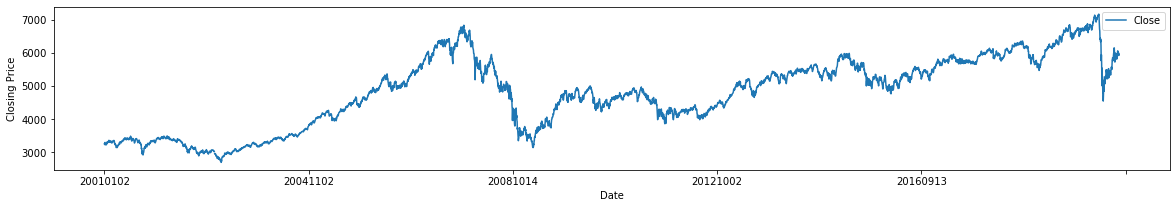

In [6]:
axjo_close.plot(kind='line', x='Date', y='Close', figsize=(20, 3))
plt.ylabel('Closing Price')
plt.xlabel('Date')
plt.show()

A sharp decline is evident on the right side of the chart. This is when the market has been hit hard by COVID-19 pandemic around Feb and Mar 2020.<br>
Let's take a closer look at the this period and see if this drastic change of trend could be predicted with moon phase.<br>
If the general belief stands true, the beginning of the fall should be preceded by full moon (FM) phase.

In [7]:
def chart_phase(period, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    sns.set(font_scale=1.2)
    sns.set_style('whitegrid')
    sns.lineplot(x=period['Date'], y=period['Close'])
    plt.xticks(rotation='vertical')
    plt.title(title, fontsize=17)
    for i, c, p in zip(period['Date'], period['Close'], period['phase']):
        if p == 'fullmoon':
            ax.annotate('FM', xy=(i, c), xytext=(i, c+400), arrowprops=dict(arrowstyle="->", connectionstyle='arc3', color='orange'), color='orange')
    for i, c, p in zip(period['Date'], period['Close'], period['phase']):
        if p == 'newmoon':
            ax.annotate('NM', xy=(i, c), xytext=(i, c-400), arrowprops=dict(arrowstyle="->", connectionstyle='arc3', color='blue'), color='blue')
    plt.show()

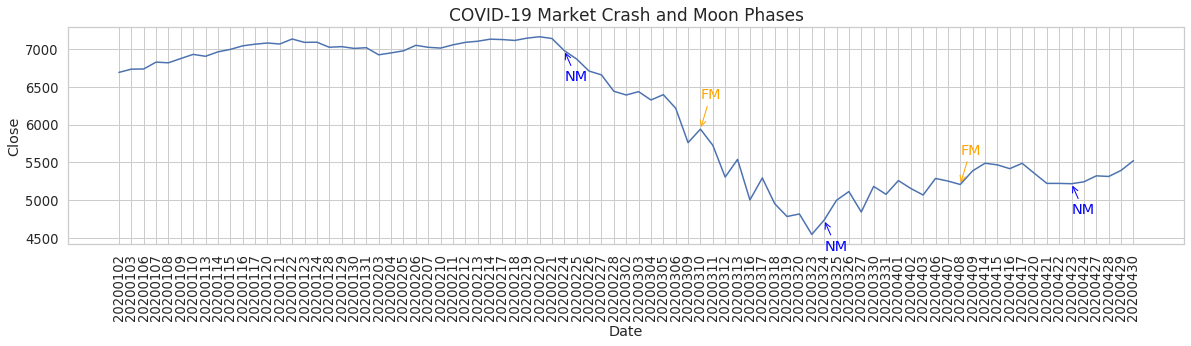

In [9]:
period1 = close_moon[(close_moon['Date'].astype(int) >= 20200101) & (close_moon['Date'].astype(int) <= 20200431) ]
chart_phase(period1, 'COVID-19 Market Crash and Moon Phases')

The fall started on 21 Feb. Instead of FM preceding the fall as in the general belief, there was actually new moon (NM) phase on 24 Feb, which is thought to precede a rise. The beginning of the downfall did not go as in the theory.<br>
However, 10 Mar marked FM phase which preceded a even steeper fall. Also, there was NM phase on 24 Mar and the price recovered thereafter.<br>
This particular period shows some level of correlation of moon phase and price trend which aligns with general belief, however it is not distinct enough.

### 3.3. Determining Direction of Price Movement
Next the direction of price movement around moon phase day will be determined.<br>
First, closing prices of 5 trading days before & after moon phase day will be added to the data frame ('5d_before' column and '5d_after' column).

In [10]:
def beforeafter(base):
    for i, close in zip(base.index, base['Close']):
        if i-5 > 0:
            close_moon.loc[i, '5d_before'] = close_moon.iloc[i-5, 1]
        if i+5 <= close_moon.shape[0]:
            close_moon.loc[i, '5d_after'] = close_moon.iloc[i+5, 1] 

In [11]:
beforeafter(close_moon[close_moon['phase']=='fullmoon'])
beforeafter(close_moon[close_moon['phase']=='newmoon'])
beforeafter(close_moon[close_moon['phase']=='1q'])
beforeafter(close_moon[close_moon['phase']=='3q'])
close_moon[close_moon['phase'].isnull()==False].head()

,Date,Close,phase,5d_before,5d_after
1,20010103,3235.699951,1q,NaN,3239.199951
6,20010110,3239.199951,fullmoon,3235.699951,3253.699951
10,20010116,3239.399902,3q,3244.899902,3288.600098
16,20010124,3297.199951,newmoon,3253.699951,3341.699951
23,20010202,3355.300049,1q,NaN,3312.399902


As shown in table below, some moon phase days have no price data on 5 trading days before/after.<br>
This is because the market was closed on that +/-5 trading day.

In [12]:
nandata = close_moon[(close_moon['phase'].isnull()==False) & ((close_moon['5d_before'].isnull()==True) | (close_moon['5d_after'].isnull()==True))]
nandata.head()

,Date,Close,phase,5d_before,5d_after
1,20010103,3235.699951,1q,NaN,3239.199951
23,20010202,3355.300049,1q,NaN,3312.399902
284,20020204,3466.100098,3q,NaN,3476.500000
318,20020322,3433.800049,1q,3407.699951,NaN
328,20020405,3390.000000,3q,NaN,3354.500000


In these cases, price of the next nearest day from the moon phase day will be used.<br>
Example:<br>
2011/12/30 (5 td before): <u>4056.600098</u><br>
2012/1/9 (Full Moon day): <u>4105.399902</u><br>
2002/1/16 (5 td after): <u>**NaN**</u> (market was closed during 1/14-16 in this year)<br>
---> Replace NaN with 2002/1/13 price of <u>**4195.899902**</u>

In [13]:
for i, b in zip(nandata.index, nandata['5d_before']):
    if str(b) == 'nan':
        if i == min(close_moon.index):
            close_moon.loc[i, '5d_before'] = close_moon.iloc[i, 1]
        for n1 in range(1, 5):
            if str(close_moon.loc[i, '5d_before']) != 'nan':
                break
            if i-(5-n1) >= 0:
                close_moon.loc[i, '5d_before'] = close_moon.iloc[i-(5-n1), 1]
    else:
        if i == max(close_moon.index):
            close_moon.loc[i, '5d_after'] = close_moon.iloc[i, 1]
        for n2 in range(1, 5):
            if str(close_moon.loc[i, '5d_after']) != 'nan':
                break
            close_moon.loc[i, '5d_after'] = close_moon.iloc[i+(5-n2), 1]

Add '5d_bef_chanege' and '5d_aft_change' columns showing percentage change of the ±5td period.

In [14]:
for i, r in close_moon[(close_moon['5d_before'].isnull() == False) | (close_moon['5d_after'].isnull() == False)].iterrows():
    close_moon.loc[i, '5d_bef_change'] = (close_moon.loc[i, 'Close'] - close_moon.loc[i, '5d_before']) / close_moon.loc[i, '5d_before'] * 100
    close_moon.loc[i, '5d_aft_change'] = (close_moon.loc[i, '5d_after'] - close_moon.loc[i, 'Close']) / close_moon.loc[i, 'Close'] * 100
close_moon[close_moon['phase'].isnull()==False].head()

,Date,Close,phase,5d_before,5d_after,5d_bef_change,5d_aft_change
1,20010103,3235.699951,1q,3261.100098,3239.199951,-0.778883,0.108168
6,20010110,3239.199951,fullmoon,3235.699951,3253.699951,0.108168,0.447641
10,20010116,3239.399902,3q,3244.899902,3288.600098,-0.169497,1.518806
16,20010124,3297.199951,newmoon,3253.699951,3341.699951,1.336940,1.349630
23,20010202,3355.300049,1q,3317.199951,3312.399902,1.148562,-1.278579


Some moon phase days have no closing price (see 'Close' column in below table) because the market was closed on that moon phase day.<br>
These data will be ignored as the number is small and will not have much impact on the results.

In [15]:
print('# of moon phase days without closing price:', close_moon[(close_moon['phase'].isnull()==False) & ((close_moon['5d_bef_change'].isnull()==True)|(close_moon['5d_aft_change'].isnull()==True))].shape[0])
close_moon[(close_moon['phase'].isnull()==False) & ((close_moon['5d_bef_change'].isnull()==True)|(close_moon['5d_aft_change'].isnull()==True))]

# of moon phase days without closing price: 3


,Date,Close,phase,5d_before,5d_after,5d_bef_change,5d_aft_change
74,20010416,NaN,3q,3215.699951,3300.600098,NaN,NaN
323,20020329,NaN,fullmoon,3433.800049,3390.000000,NaN,NaN
2819,20120116,NaN,3q,4105.399902,4225.100098,NaN,NaN


Now the dataset has the %change figures over ±5 trading days ('5d_bef_change' column and '5d_aft_change' column) and is ready to be examined.

In [16]:
close_moon[close_moon['phase'].isnull()==False].head()

,Date,Close,phase,5d_before,5d_after,5d_bef_change,5d_aft_change
1,20010103,3235.699951,1q,3261.100098,3239.199951,-0.778883,0.108168
6,20010110,3239.199951,fullmoon,3235.699951,3253.699951,0.108168,0.447641
10,20010116,3239.399902,3q,3244.899902,3288.600098,-0.169497,1.518806
16,20010124,3297.199951,newmoon,3253.699951,3341.699951,1.336940,1.349630
23,20010202,3355.300049,1q,3317.199951,3312.399902,1.148562,-1.278579


### 3.4. Results
We will now see the distribution of cases in below matrix.<br>
X-axis describes how much in percentage the price has moved <u>from 5 td before to moon phase day</u>.<br>
Y-axis describes how much in percentage the price has moved <u>from moon phase day to 5 td later</u>.<br>
Gray arrows on the background describe the direction shift.

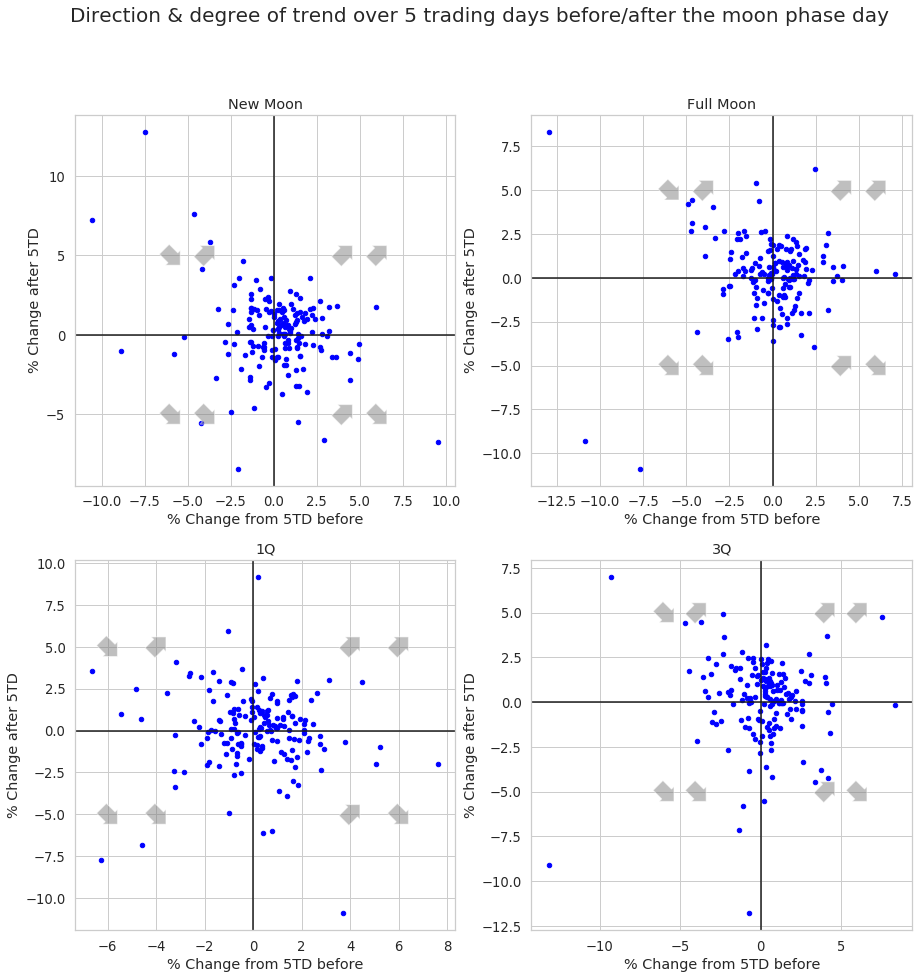

In [17]:
plot_fm = close_moon[(close_moon['phase']=='fullmoon') & (close_moon['5d_bef_change'].isnull()==False)][['5d_bef_change', '5d_aft_change']]
plot_nm = close_moon[(close_moon['phase']=='newmoon') & (close_moon['5d_bef_change'].isnull()==False)][['5d_bef_change', '5d_aft_change']]
plot_1q = close_moon[(close_moon['phase']=='1q') & (close_moon['5d_bef_change'].isnull()==False)][['5d_bef_change', '5d_aft_change']]
plot_3q = close_moon[(close_moon['phase']=='3q') & (close_moon['5d_bef_change'].isnull()==False)][['5d_bef_change', '5d_aft_change']]

fig = plt.figure()
fig.suptitle('Direction & degree of trend over 5 trading days before/after the moon phase day', fontsize=20)
ax0, ax1, ax2, ax3 = fig.add_subplot(2, 2, 1), fig.add_subplot(2, 2, 2), fig.add_subplot(2, 2, 3), fig.add_subplot(2, 2, 4)
ax_list = [ax0, ax1, ax2, ax3]
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="gray", alpha=0.5)
phase = [plot_nm, plot_fm, plot_1q, plot_3q, 'New Moon', 'Full Moon', '1Q', '3Q']
for i in range(0, 4):
    ax_num = ax_list[i]
    phase[i].plot(kind='scatter', x='5d_bef_change', y='5d_aft_change', figsize=(15, 15), color='blue', ax=ax_num)
    ax_num.axhline(y=0, color='k')
    ax_num.axvline(x=0, color='k')
    ax_num.text(-6, 5, "     ", ha="center", va="center", rotation=-45, size=8, bbox=bbox_props)
    ax_num.text(-4, 5, "     ", ha="center", va="center", rotation=45, size=8, bbox=bbox_props)
    ax_num.text(4, 5, "     ", ha="center", va="center", rotation=45, size=8, bbox=bbox_props)
    ax_num.text(6, 5, "     ", ha="center", va="center", rotation=45, size=8, bbox=bbox_props)
    ax_num.text(-6, -5, "     ", ha="center", va="center", rotation=-45, size=8, bbox=bbox_props)
    ax_num.text(-4, -5, "     ", ha="center", va="center", rotation=-45, size=8, bbox=bbox_props)
    ax_num.text(4, -5, "     ", ha="center", va="center", rotation=45, size=8, bbox=bbox_props)
    ax_num.text(6, -5, "     ", ha="center", va="center", rotation=-45, size=8, bbox=bbox_props)
    ax_num.set_title(str(phase[i+4]))
    ax_num.set_xlabel('% Change from 5TD before')
    ax_num.set_ylabel('% Change after 5TD')
plt.show()

There are outliers on the chart, some of which exceed as much as 10%, but most cases cluster around 0-5% in any moon phase.<br>
General belief says NM precedes up trend and FM precedes down trend. According to this theory, there are expected to be more cases in upper side of the matrix for NM and lower side for FM, however the result was not so distinct.<br>
Although the distribution looks quite similar in all four moon phases, there seem to be slightly more cases in upper right side of the matrix (i.e. 'up and up' trend) in NM and 3Q phases. Let's see the distribution in figures.

In [18]:
print('Distribution of trend patterns')
pct_cng = close_moon[close_moon['phase'].isnull()==False]
for i, b, a in zip(pct_cng.index, pct_cng['5d_bef_change'], pct_cng['5d_aft_change']):
    if (b<0) & (a>0):
        trend = 'Down, Up'
    elif (b>0) & (a>0):
        trend = 'Up, Up'
    elif (b<0) & (a<0):
        trend = 'Down, Down'
    else:
        trend = 'Up, Down'
    close_moon.loc[i, 'trend'] = trend
phase = ['newmoon','1q','fullmoon','3q']
trend = ['Down, Up', 'Down, Down', 'Up, Up', 'Up, Down']
for p in phase:
    print('\n', '------', p, '------')
    phase_count = close_moon[close_moon['phase']==p].shape[0]
    for t in trend:
        trend_count = close_moon[(close_moon['phase']==p) & (close_moon['trend']==t)].shape[0]
        print(t, ':   ', trend_count, '(' + str(trend_count/phase_count*100)[:5] + '%)')

Distribution of trend patterns

 ------ newmoon ------
Down, Up :    36 (21.30%)
Down, Down :    32 (18.93%)
Up, Up :    58 (34.31%)
Up, Down :    43 (25.44%)

 ------ 1q ------
Down, Up :    39 (22.94%)
Down, Down :    33 (19.41%)
Up, Up :    54 (31.76%)
Up, Down :    44 (25.88%)

 ------ fullmoon ------
Down, Up :    47 (28.14%)
Down, Down :    27 (16.16%)
Up, Up :    53 (31.73%)
Up, Down :    40 (23.95%)

 ------ 3q ------
Down, Up :    38 (22.61%)
Down, Down :    24 (14.28%)
Up, Up :    61 (36.30%)
Up, Down :    45 (26.78%)


In FM phase, general belief doesn't stand true at all. It was expected to precede down trend in theory, but the results were 23.95% for 'up & down' trend and only 16.16% for 'down & down' trend.<br>
Contrary to the general belief, it actually showed a tendency to move up after FM day, whether the pre-trend is up or down.<br>
When the trend over the past 5td is down --> 47 out of 74 cases will move up (63.51% probability)<br>
When the trend over the past 5td is up --> 53 out of 93 cases will move up (56.98% probability)<br>
Let's now see the probability of occurrence for every pattern according to each pre-trend.<br>

In [19]:
def prob(df):
    for p in phase:
        print('\n', '------', p, '------')
        for t in trend:
            if t[:4] == 'Down':
                pre_trend = 'Down'
                if t[-4:] == 'Down':
                    post_trend = 'Down'
                else:
                    post_trend = 'Up'
                pre_trend_count = df[(df['phase']==p) & ((df['trend']==trend[0]) | (df['trend']==trend[1]))].shape[0]
            else:
                pre_trend = 'Up'
                if t[-4:] == 'Down':
                    post_trend = 'Down'
                else:
                    post_trend = 'Up'
                pre_trend_count = df[(df['phase']==p) & ((df['trend']==trend[2]) | (df['trend']==trend[3]))].shape[0]
            trend_count = df[(df['phase']==p) & (df['trend']==t)].shape[0]
            print('Pre-trend:', pre_trend, '---->', trend_count, 'out of', pre_trend_count, 'moved', post_trend, '(Probability: ' + str(trend_count/pre_trend_count*100)[:5] + '%)')

In [20]:
print('Probability of occurrence')
prob(close_moon)

Probability of occurrence

 ------ newmoon ------
Pre-trend: Down ----> 36 out of 68 moved Up (Probability: 52.94%)
Pre-trend: Down ----> 32 out of 68 moved Down (Probability: 47.05%)
Pre-trend: Up ----> 58 out of 101 moved Up (Probability: 57.42%)
Pre-trend: Up ----> 43 out of 101 moved Down (Probability: 42.57%)

 ------ 1q ------
Pre-trend: Down ----> 39 out of 72 moved Up (Probability: 54.16%)
Pre-trend: Down ----> 33 out of 72 moved Down (Probability: 45.83%)
Pre-trend: Up ----> 54 out of 98 moved Up (Probability: 55.10%)
Pre-trend: Up ----> 44 out of 98 moved Down (Probability: 44.89%)

 ------ fullmoon ------
Pre-trend: Down ----> 47 out of 74 moved Up (Probability: 63.51%)
Pre-trend: Down ----> 27 out of 74 moved Down (Probability: 36.48%)
Pre-trend: Up ----> 53 out of 93 moved Up (Probability: 56.98%)
Pre-trend: Up ----> 40 out of 93 moved Down (Probability: 43.01%)

 ------ 3q ------
Pre-trend: Down ----> 38 out of 62 moved Up (Probability: 61.29%)
Pre-trend: Down ----> 24 ou

Results for NM phase were a bit more in line with the general belief (i.e. NM preceding up trend). Whether its preceding trend is up or down, it moved up after NM.<br>
The pattern with highest probability of occurrence is when preceding trend is down and it moves up after FM (63.51%). In other words, entering into long position on full moon day when the trend over the past 5td is down is the least risky strategy among all moon phase days' trades based on the last 20 years' data.<br>
Although we could not justify general belief of full moon, at least some tendencies were evident with this result.

## 4. Probability of Winning Big
We observed some outliers in the distribution matrix above. Of these outliers, those with high percentage change after 5 trading days (y-axis on the matrix), whether it's positive or negative change, give a trader an opportunity to gain a high rate of return.<br>
In this section, cases of ±5% or greater movement after moon phase day will be analysed in order to find when and how a trader might be able to achieve this.
### 4.1. Number of Moon Phase Days Preceding ±5%< Change
Let's see how many moon phase days there were in the past 20 years which preceded ±5%< change.

In [21]:
big_win = close_moon[(close_moon['5d_aft_change']>5) | (close_moon['5d_aft_change']<-5)][['Date', 'phase', '5d_aft_change']]
print('Number of occurrence: ', big_win.shape[0])
big_win

Number of occurrence:  27


,Date,phase,5d_aft_change
180,20010911,3q,-7.152989
189,20010924,1q,5.959782
1787,20071210,newmoon,-5.458032
1811,20080116,1q,-6.840291
1815,20080122,fullmoon,8.326915
1842,20080229,3q,-5.529335
1922,20080626,3q,-5.816849
1989,20080929,newmoon,-5.553938
1995,20081007,1q,-6.138091
2005,20081021,3q,-11.804762


That occurred only 27 times in the past 20 years (=1.35 times in a year).<br>
The chance is quite slim, but if we look at 'Date' column majority of cases occurred in 2008 and 2020. There seems to be some tendency for it to occur in a certain period of time.

### 4.2. Analysing Timing
To get some insight, price movement of the whole 20 years will be observed once again, along with the dates ±5%< movements occurred.<br>
First data frame needs to be tidied up to get it fitted to the chart.

In [22]:
date_list = []
for d in big_win.itertuples():
    big_win.loc[d[0], d[2]] = d[3]
    big_win.loc[d[0], 'Date'] = d[1][:6]
temp_list =[]
for y in range(2001,2021):
    for m in range(1, 13):
        temp_list.append(str(y)+ '%02.0f' %m)
        if (y==2020) & (m==7):
            break
temp = pd.DataFrame.from_dict({'Date':temp_list})
big_win_plot = pd.merge(big_win, temp, left_on='Date', right_on='Date', how='right')
big_win_plot.drop('5d_aft_change', axis=1, inplace=True)
big_win_plot.sort_values(by='Date', inplace=True)
big_win_plot = big_win_plot.groupby('Date', as_index=False).sum()
big_win_plot.head()

,Date,3q,1q,newmoon,fullmoon
0,200101,0.0,0.0,0.0,0.0
1,200102,0.0,0.0,0.0,0.0
2,200103,0.0,0.0,0.0,0.0
3,200104,0.0,0.0,0.0,0.0
4,200105,0.0,0.0,0.0,0.0


Here is a chart of closing prices over the past 20 years (line chart) and the moon phase days that preceded ±5< change (bar chart).

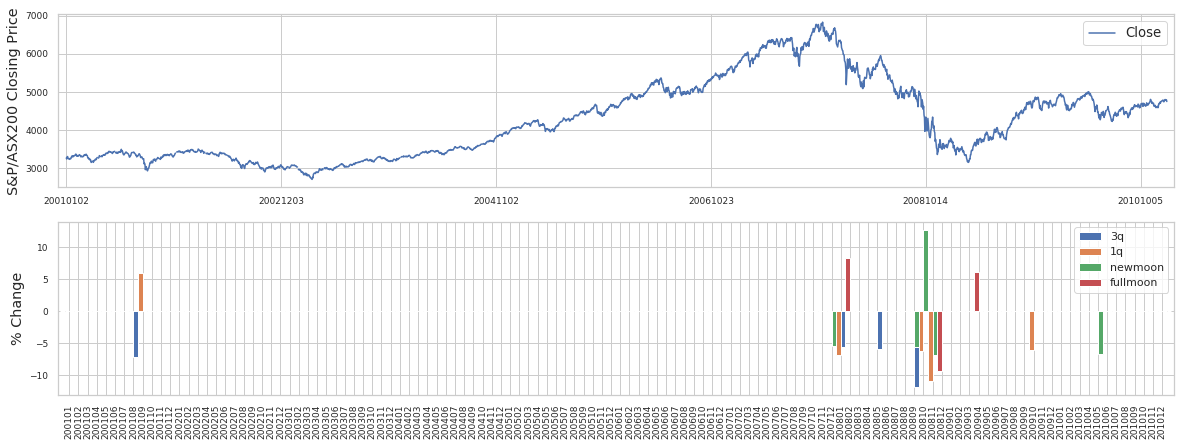

In [23]:
period3 = big_win_plot[(big_win_plot['Date'].astype(int) >= 200101) & (big_win_plot['Date'].astype(int) <= 201012)]
period4 = big_win_plot[(big_win_plot['Date'].astype(int) >= 201101) & (big_win_plot['Date'].astype(int) <= 202012)]
axjop3 = axjo_close[(axjo_close['Date'].astype(int) >= 20010101) & (axjo_close['Date'].astype(int) <= 20101231)]
axjop4 = axjo_close[(axjo_close['Date'].astype(int) >= 20110101) & (axjo_close['Date'].astype(int) <= 20201231)]

fig = plt.figure()
ax0 = fig.add_subplot(2, 1, 1)
ax1 = fig.add_subplot(2, 1, 2)

axjop3.plot(kind='line', x='Date', y='Close', figsize=(20, 7), fontsize=9, ax=ax0)
ax0.set_xlabel('')
ax0.set_xlim(-20, axjop4.shape[0]+170)
ax0.set_ylabel('S&P/ASX200 Closing Price')

period3.plot(kind='bar', x='Date', figsize=(20, 7), fontsize=9, width=2, ax=ax1)
ax1.legend(fontsize=11)
ax1.set_xlabel('')
ax1.set_ylabel('% Change')

plt.show()

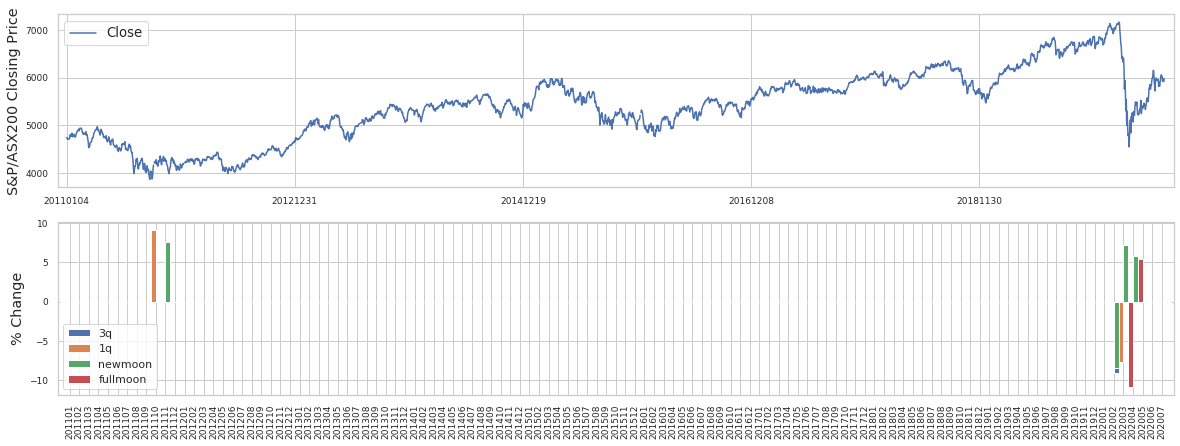

In [24]:
fig = plt.figure()
ax2 = fig.add_subplot(2, 1, 1)
ax3 = fig.add_subplot(2, 1, 2)

axjop4.plot(kind='line', x='Date', y='Close', figsize=(20, 7), fontsize=9, ax=ax2)
ax2.set_xlabel('')
ax2.set_xlim(-20, axjop4.shape[0]+20)
ax2.set_ylabel('S&P/ASX200 Closing Price')

period4.plot(kind='bar', x='Date', figsize=(20, 7), fontsize=9, width=2, ax=ax3)
ax3.legend(fontsize=11)
ax3.set_xlabel('')
ax3.set_ylabel('% Change')

plt.show()

We can see that most cases occurred during the time of high volatility (e.g. financial crisis). Because the market itself is in a volatile period, it is just natural that the price movement after moon phase day also tends to be large. What's more important for a trader in trading in this kind of environment will be the direction of the trend after the moon phase day. 

### 4.3. Trading Strategy
With above chart in mind, an aggressive trader who aims at 5%< return might enter a position in a volatile period such as financial crisis.<br>
The trader might also want to determine whether to enter long/short position. Listed below is the probability of occurrence for patterns that exceeded ±5% change after moon phase day. It is easy to refer to these figures and just follow the direction with higher probability, however the percentage of probability distribution is signified due to small number of samples, so it should not be completely relied on.

In [25]:
big_win_trend = close_moon[(close_moon['5d_aft_change']>5) |
                           (close_moon['5d_aft_change']<-5)][['Date', 'phase', '5d_aft_change', '5d_aft_change', 'trend']]
print('Probability of occurrence of ±5%< change after moon phase day')
prob(big_win_trend)

Probability of occurrence of ±5%< change after moon phase day

 ------ newmoon ------
Pre-trend: Down ----> 4 out of 6 moved Up (Probability: 66.66%)
Pre-trend: Down ----> 2 out of 6 moved Down (Probability: 33.33%)
Pre-trend: Up ----> 0 out of 3 moved Up (Probability: 0.0%)
Pre-trend: Up ----> 3 out of 3 moved Down (Probability: 100.0%)

 ------ 1q ------
Pre-trend: Down ----> 1 out of 3 moved Up (Probability: 33.33%)
Pre-trend: Down ----> 2 out of 3 moved Down (Probability: 66.66%)
Pre-trend: Up ----> 1 out of 4 moved Up (Probability: 25.0%)
Pre-trend: Up ----> 3 out of 4 moved Down (Probability: 75.0%)

 ------ fullmoon ------
Pre-trend: Down ----> 2 out of 4 moved Up (Probability: 50.0%)
Pre-trend: Down ----> 2 out of 4 moved Down (Probability: 50.0%)
Pre-trend: Up ----> 1 out of 1 moved Up (Probability: 100.0%)
Pre-trend: Up ----> 0 out of 1 moved Down (Probability: 0.0%)

 ------ 3q ------
Pre-trend: Down ----> 1 out of 5 moved Up (Probability: 20.0%)
Pre-trend: Down ----> 4 out 

## 5. Building Prediction Model
Lastly, we are going to see whether it is possible to predict a future price movement by moon phase, using machine learning techniques.<br>
Two types of machine learning techniques are used: Multiple Linear Regression (MLR) and Polynomial Regression.
### 5.1. Pre-processing
The dataset will be cleaned again.<br>
Categorical variables such as 'fullmoon' and 'newmoon' will be encoded to numerical values.<br>
For comparison purpose, some factors other than moon phase ('phase' column of the data frame) will also be added to the data frame, such as the month of the date ('month' column), opening/high/low price of the day ('axjo_open'/'axjo_high'/'axjo_low' column), and preceding trend ('pre_trend' column).

In [26]:
axjo_df = axjo.copy()
axjo_df['Date'] = axjo_df['Date'].str.replace('-','')
axjo_df.rename(columns={'Open':'axjo_open', 'High':'axjo_high', 'Low':'axjo_low'}, inplace=True)
axjo_df.drop(['Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

pred = close_moon.copy()
pred = pd.merge(pred, axjo_df, left_on='Date', right_on='Date', how='right')
pred = pred[pred['phase'].isnull()==False].copy()
pred['Date'] = pred['Date'].str[4:6]
pred['pre_trend'] = pred['trend'].str[:2]
pred['post_trend'] = pred['trend'].str[-4:]
pred.rename(columns={'Date':'month'}, inplace=True)
pred.drop(['5d_after', 'trend'], axis=1, inplace=True)
pred.drop(pred[pred['Close'].isnull()==True].index, axis=0, inplace=True)
lb_make = LabelEncoder()
for c in ['month', 'phase', 'pre_trend', 'post_trend']: # mth:0+1=month. phase:0=1q,2=fm,1=3q,3=nm. pre_trend:0=down,1=up.
    pred[c] = lb_make.fit_transform(pred[c])
pred.head()

,month,Close,phase,5d_before,5d_bef_change,5d_aft_change,axjo_open,axjo_high,axjo_low,pre_trend,post_trend
1,0,3235.699951,0,3261.100098,-0.778883,0.108168,3260.399902,3260.399902,3225.000000,0,0
6,0,3239.199951,2,3235.699951,0.108168,0.447641,3245.000000,3247.000000,3228.199951,1,0
10,0,3239.399902,1,3244.899902,-0.169497,1.518806,3250.300049,3250.300049,3239.199951,0,0
16,0,3297.199951,3,3253.699951,1.336940,1.349630,3288.500000,3298.800049,3284.600098,1,0
23,1,3355.300049,0,3317.199951,1.148562,-1.278579,3362.699951,3362.699951,3348.600098,1,1


### 5.2. Factors Affecting Post-Moon Phase Trend
Here is a list of factors and their correlation to the price movement after 5 trading days ('5d_aft_change' column).

In [27]:
print('Correlation to \'5d_aft_change\'')
pred.corr()[['5d_aft_change']]

Correlation to '5d_aft_change'


,5d_aft_change
month,-0.017831
Close,-0.093445
phase,0.016301
5d_before,-0.085589
5d_bef_change,-0.096422
5d_aft_change,1.000000
axjo_open,-0.091483
axjo_high,-0.094339
axjo_low,-0.089148
pre_trend,-0.063678


It looks like most factors are not really correlated.<br>
Actually, correlation of moon phase ('phase' column) is just 0.016, which is much smaller than other factors. We might be able to build a better model by adding several factors together with moon phase, but it will dilute the impact of moon phase as a predictor. Main focus of this prediction model is using moon phase as the predicting factor, so we only add one factor '5d_bef_change' as a supportive variable for the prediction model.<br>
The inputs to the MLR prediction model will be:<br>
- Dependent variable (Y) = '5d_aft_change'<br>
- Independent variables (X) = 'phase' and '5d_bef_change'<br>

With the correlation figure alone not much reliability is expected from the prediction model, but let's just build one and see how it goes.
### 5.3. MLR Model
Now dependent and independent variables will be input to build an MLR model.

In [28]:
X = pred[['phase', '5d_bef_change']]
Y = pred['5d_aft_change']
lm = LinearRegression()
lm.fit(X, Y)
yhat_mlr = lm.predict(X)

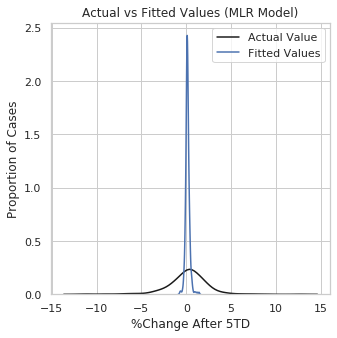

In [29]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1, style='whitegrid')
ax1 = sns.distplot(Y, hist=False, color="k", label='Actual Value')
ax2 = sns.distplot(yhat_mlr, hist=False, color="b", label='Fitted Values', ax=ax1)
plt.title('Actual vs Fitted Values (MLR Model)')
plt.xlabel('%Change After 5TD')
plt.ylabel('Proportion of Cases')
plt.show()

The MLR model doesn't seem to fit well with actual value. Most of the fitted values were distributed around 0% change, so the model prediction looks quite conservative.<br>
Let's evaluate this model using internal test samples and get R^2 score, which measures how much variation of a dependent variable (Y) is explained by the independent variables (X).

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=3)
lm.fit(x_train, y_train)
print('R^2 score:', lm.score(x_test, y_test))
print('Coefficient:', lm.coef_)
print('Intercept:', lm.intercept_)

R^2 score: 0.007982381836420749
Coefficient: [ 0.04367101 -0.05094693]
Intercept: 0.024101799183467387


It scored even less than 1%.<bR>
As expected, it was not a good prediction model.
### 5.4. Polynomial Regression Model
Next model to be built and tested is Polynomial Regression model.<br>
Same dependent (Y) and independent (X) variables are used, but X will be transformed to 2nd to 5th polynomials.

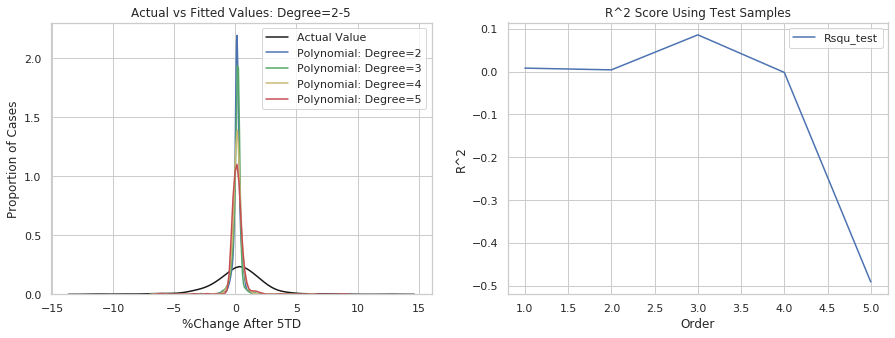

--- Degree 1 ---
R^2 score: 0.00798238183642086
Coefficient: [ 0.          0.04367101 -0.05094693]
Intercept: 0.024101799183467318 

--- Degree 2 ---
R^2 score: 0.003906341297158278
Coefficient: [ 0.          0.26769492  0.03234652 -0.07021424 -0.0685952  -0.0128254 ]
Intercept: 0.000364397659093435 

--- Degree 3 ---
R^2 score: 0.08568896814921845
Coefficient: [ 0.          0.25580901 -0.06582584 -0.09883138  0.09215834 -0.02956593
  0.00529038 -0.04895028  0.01215403  0.0004412 ]
Intercept: 0.0655158711477196 

--- Degree 4 ---
R^2 score: -0.00209495944192728
Coefficient: [ 0.00000000e+00  9.04160079e-02 -2.09675665e-01  1.25832319e-02
 -6.50507233e-01 -3.10045483e-02 -6.44920912e-02  7.03048874e-01
  5.77177513e-02  1.18930322e-02  1.71279492e-02 -1.55866077e-01
 -1.72375570e-02 -5.74611583e-03  2.68073882e-05]
Intercept: 0.11250081475412854 

--- Degree 5 ---
R^2 score: -0.49160540325460267
Coefficient: [ 0.00000000e+00 -3.86105737e-01 -2.26826107e-01 -2.24740160e-01
 -2.22264234e-

In [31]:
c = ['b', 'g', 'y', 'r']
fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
sns.distplot(Y, hist=False, color="k", label="Actual Value", ax=ax0)
sns.set(font_scale=1, style='whitegrid')
for i in range(2, 6):
    pr = PolynomialFeatures(degree=i)
    x_pr = pr.fit_transform(X)    
    lm.fit(x_pr, Y)
    yhat_poly = lm.predict(x_pr)
    sns.distplot(yhat_poly, hist=False, color=c[i-2], label='Polynomial: ' + 'Degree=' + str(i), ax=ax0)
Rsqu_test = []
coef = []
ic = []
order = [1, 2, 3, 4, 5]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train)
    x_test_pr = pr.fit_transform(x_test)    
    lm.fit(x_train_pr, y_train)
    Rsqu_test.append(lm.score(x_test_pr, y_test))
    coef.append(lm.coef_)
    ic.append(lm.intercept_)
pd.DataFrame.from_dict({'order':order, 'Rsqu_test':Rsqu_test}).plot(x='order', y='Rsqu_test', ax=ax1)
ax0.set_title('Actual vs Fitted Values: Degree=2-5')
ax0.set_xlabel('%Change After 5TD')
ax0.set_ylabel('Proportion of Cases')
ax1.set_xlabel('Order')
ax1.set_ylabel('R^2')
ax1.set_title('R^2 Score Using Test Samples')
plt.show()
for i in range(1,6):
    print('--- Degree', i, '---')
    print('R^2 score:', Rsqu_test[i-1])
    print('Coefficient:', coef[i-1])
    print('Intercept:', ic[i-1], '\n')

Model with highest R^2 score was the Polynomial Regression model of degree 3, but its R^2 score is still way too small and it is not a viable model to be used.<br>
Unfortunately, Neither MLR nor Polynomial Regression model showed practical level of reliability.
## 6. Conclusion
With the analysis of the past 20 years' S&P/ASX200 market data and the moon phase days in that period, general belief of moon phase affecting the price movement was not clearly evident. However, it showed some other tendencies such as downward trend before full moon followed by upward trend after the full moon day.<br>
The analysis also found that the percentage of price movement after moon phase day mostly aligns with the volatility of the market. When a trader is seeking a higher rate of return on a moon phase day, he/she might enter into a position in a volatile period, such as major financial crisis. As the probability of occurrence varies depending on the preceding trend and moon phase, the trader can use it as a reference when deciding long or short position, however due to small samples this is not to be completely relied on.<br>
We also explored possibility of building a prediction model that predict future price movement based on moon phase and preceding trend. Multiple Linear Regression model and Polynomial Regression model were built and tested, however both of these models did not show an acceptable level of performance and turned out to be unviable. This is largely due to small correlation between moon phase and price movement after the moon phase day.